In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# 'cs231n' folder containing the '.py', 'classifiers' and 'datasets'
# folders.
# e.g. 'cs231n/assignments/assignment1/cs231n/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#!curl https://colab.chainer.org/install | sh - #Cupy applying GPU to accelerate numpy operation

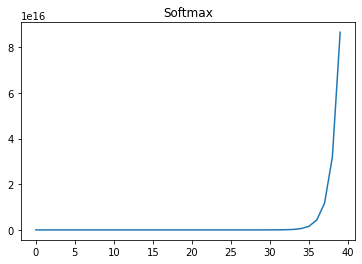

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(40)
x_e_sum = np.sum(np.exp(x))
y = np.exp(x)
plt.plot(x,y)
plt.title('Softmax')
plt.show()

In [ ]:
FOLDERNAME = 'cs231n/assignments/assignment1/cs231n/'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive/cs231n/assignments/assignment1/cs231n/datasets
!bash get_datasets.sh
%cd ../../

/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
import random
import numpy as np
import cupy as cp
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


In [ ]:
a = np.arange(3)[:,np.newaxis]
b = np.arange(4)[np.newaxis,:]
print(a)
print(b)
a*b

[[0]
 [1]
 [2]]
[[0 1 2 3]]


array([[0, 0, 0, 0],
       [0, 1, 2, 3],
       [0, 2, 4, 6]])

## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [ ]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.356944
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ For random W, $$E(\hat{y}_i)=0.1$$ Therefore, for each X, $$E(loss)=-ln(0.1)$$ The finally loss $$E(L)=\frac{-ln(0.1)N}{N}+reg*sum(W*W)$$ As the initial of W is very small so that W*W is close to 0. Therefore, $$E(L)\approx-ln(0.1)$$



In [ ]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.671182 analytic: 0.671182, relative error: 5.770126e-08
numerical: 0.643742 analytic: 0.643742, relative error: 1.107438e-07
numerical: 2.157081 analytic: 2.157081, relative error: 3.631738e-08
numerical: -0.361737 analytic: -0.361737, relative error: 5.476867e-08
numerical: 0.184885 analytic: 0.184885, relative error: 2.243075e-07
numerical: 0.257051 analytic: 0.257051, relative error: 3.132042e-08
numerical: 1.262319 analytic: 1.262319, relative error: 2.240305e-08
numerical: -1.094354 analytic: -1.094354, relative error: 2.360632e-08
numerical: 0.688011 analytic: 0.688011, relative error: 1.203038e-07
numerical: -4.196861 analytic: -4.196861, relative error: 1.502931e-08
numerical: 0.525526 analytic: 0.525526, relative error: 9.675543e-08
numerical: 1.723605 analytic: 1.723605, relative error: 8.691877e-09
numerical: 0.053235 analytic: 0.053235, relative error: 2.353840e-07
numerical: -3.441688 analytic: -3.441688, relative error: 1.151952e-08
numerical: -0.103035 analy

In [ ]:
A = np.arange(12).reshape(3,4)
print(A)
B = cp.array(A)
C = cp.array(B)
print(C)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]


In [ ]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.356944e+00 computed in 0.636493s
vectorized loss: 2.356944e+00 computed in 2.373007s
Loss difference: 0.000000
Gradient difference: 0.000000


In [ ]:
A = np.arange(10)
B = np.arange(10)
print(sum(A==B))

10


In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
st = time.time()
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = np.linspace(1e-7, 5e-7,5) #grid search
regularization_strengths = np.linspace(2.5e4, 5e4,10)

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
  for reg in regularization_strengths:
    classifier = Softmax()
    classifier.train(X_train, y_train, lr, reg, num_iters = 2000)
    y_train_pre = classifier.predict(X_train)
    y_val_pre = classifier.predict(X_val)
    train_accuracy = np.mean(y_train_pre == y_train)
    val_accuracy = np.mean(y_val_pre == y_val)
    results[(lr,reg)] = (train_accuracy, val_accuracy)
    if val_accuracy > best_val:
      best_val = val_accuracy
      best_softmax = classifier

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
ed = time.time()
print('Time cost is: {}'.format(ed-st))

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.330306 val accuracy: 0.343000
lr 1.000000e-07 reg 2.777778e+04 train accuracy: 0.328571 val accuracy: 0.342000
lr 1.000000e-07 reg 3.055556e+04 train accuracy: 0.321041 val accuracy: 0.335000
lr 1.000000e-07 reg 3.333333e+04 train accuracy: 0.325776 val accuracy: 0.340000
lr 1.000000e-07 reg 3.611111e+04 train accuracy: 0.313837 val accuracy: 0.332000
lr 1.000000e-07 reg 3.888889e+04 train accuracy: 0.321143 val accuracy: 0.333000
lr 1.000000e-07 reg 4.166667e+04 train accuracy: 0.309286 val accuracy: 0.323000
lr 1.000000e-07 reg 4.444444e+04 train accuracy: 0.306327 val accuracy: 0.319000
lr 1.000000e-07 reg 4.722222e+04 train accuracy: 0.313633 val accuracy: 0.333000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.308571 val accuracy: 0.326000
lr 2.000000e-07 reg 2.500000e+04 train accuracy: 0.329959 val accuracy: 0.343000
lr 2.000000e-07 reg 2.777778e+04 train accuracy: 0.324980 val accuracy: 0.341000
lr 2.000000e-07 reg 3.055556

In [ ]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.342000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$True


$\color{blue}{\textit Your Explanation:}$ In SVM， when one datapoint is classified correctly it's contirbution to the loss is very likely to be 0 when it's margin with all the other classes are larger than the constant value you defined. However, in softmax, it's almost impossible that the datapoint and weight set make a one hot vector which contributes 0 to the final loss.



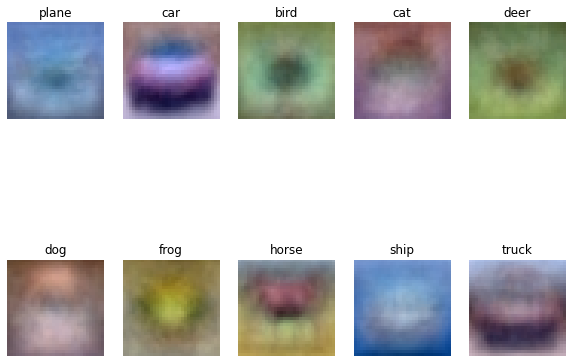

In [ ]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

---
# IMPORTANT

This is the end of this question. Please do the following:

1. Click `File -> Save` to make sure the latest checkpoint of this notebook is saved to your Drive.
2. Execute the cell below to download the modified `.py` files back to your drive.

In [ ]:
import os

FOLDER_TO_SAVE = os.path.join('drive/My Drive/', FOLDERNAME)
FILES_TO_SAVE = ['cs231n/classifiers/softmax.py']

for files in FILES_TO_SAVE:
  with open(os.path.join(FOLDER_TO_SAVE, '/'.join(files.split('/')[1:])), 'w') as f:
    f.write(''.join(open(files).readlines()))